# Dispersion Relation of Transverse-field Ising Model and Time Evolution of Wave Packet

This notebook has two parts. 

The first part presents a sample code for computing the dispersion relation of transverse-field ising model, and the numerical results are compared with analytical solutions obtained by Jodan-Wigner and Bogliubov transformation.

The second part presents the time evolution of a Gaussian wave packet on a tight-binding chain with a gradient field, in which we can observe the Bloch oscillation.

# Dispersion Relation of Transverse-filed Ising Model

Here we consider a transverse-field ising model on an N-site ring.

The Hamiltonian is
$$
H = -J\sum_{i=1}^N (g\sigma_i^x+\sigma_i^z\sigma_{i+1}^z), i\in \mathbb{Z}_N
$$

where we take two sets of parameters $J=1, g=1.6$ and $J=1, g=0.6$.

In [1]:
paramList = [(8, 1, 1.6), (8, 1, 0.6), (4, 1, 1.6), (4, 1, 0.6)]

## Basic Bit Operations

First, let's define some basic bit operations for later use.


In [2]:
def countBinOnes(num):
    return bin(num).count('1')

def concatBins(left, right, leftShift=6):
    return (left << leftShift) + right

def splitBins(num, cutFromRight=6):
    return num >> cutFromRight, num % (1 << cutFromRight)

def readBit(num, n):
    return (num & (1 << n)) >> n

def flipBit(num, n):
    return num ^ (1 << n)

def pickBits(num, start, n):
    return (num & ((2 ** n - 1) << start)) >> start

def rotLBit(num, length, n):
    return (pickBits(num, 0, length-n) << n) + (num >> (length-n))

def rotRBit(num, length, n):
    return (pickBits(num, 0, n) << (length - n)) + (num >> n)


## Constructing Hamiltonian and Translation Operator

Now, we counstruct of the Hamiltonian $H$ and Translation Operator $T$ (e.g. $T\ket{10100} = \ket{01001}$).


In [3]:
import numpy as np
from scipy import sparse

def getHT(N, J, g):

    length = 2 ** N

    # Hamiltonian
    HFrom = []
    HTo = []
    HValue = []

    # Translation
    TFrom = []
    TTo = []
    TValue = []

    for fromBasis in range(length):

        # H: off-diagonal
        for pos in range(N):
            HFrom.append(fromBasis)
            HTo.append(flipBit(fromBasis, pos))
            HValue.append(-J * g)

        # H: diagonal
        HFrom.append(fromBasis)
        HTo.append(fromBasis)
        shift = rotLBit(fromBasis, N, 1)
        numDiff = bin(fromBasis ^ shift).count('1')
        HValue.append(-J * (N - numDiff - numDiff))

        # T:
        TFrom.append(fromBasis)
        TTo.append(rotLBit(fromBasis, N, 1))
        TValue.append(1)

    H = sparse.coo_matrix((HValue, (HTo, HFrom)), shape=(length, length)).toarray()
    T = sparse.coo_matrix((TValue, (TTo, TFrom)), shape=(length, length)).toarray()

    return H, T

## Diagonalizing (Using Linear Combinations to Avoid Degeneracies and Obtain Concurrent Eigenvectors)

Since the Hamiltonian admits translational symmetry, we have $[H, T] = 0$. 

Therefore, there exists a set of basis states that can diagonalize $H$ and $T$ simultaneously. 

However, when using `numpy.linalg.eig`, we can only diagonalize one matrix at a time.

**Due to degeneracies, if we do the diagonalization one by one in a specific order, the resulted eigenvectors from the last matrix may not be the eigenvectors of the next.**

The same reason forbids us from getting concurrent eigenvectors by diagonalizing $HT$, since they might have intersected eigenspaces.

Here we develop an ad-hoc method using linear combinations to avoid degeneracies.

Specifically, we can diagonalize the linear combination $$H + xT, $$ and by tuning the parameter $x$, we can seperate $H$ & $T$'s eigenspaces, and obtain a set of concurrent eigenvectors.

Here we take $x=1$ and diagonalize $H + T$ to obtain their concurrent eigen $\ket{E, k}$:
$$
(H+T)\ket{E, k} = (E+e^{ik})\ket{E, k}
$$

However, there's a problem regarding the sign of the energy.

But we can make use of the eigenvectors to obtain $E$ and $k$ seperately.

In [6]:
def getDispersion(H, T):
    HTEigVal, HTEigVec = np.linalg.eig(H + T)
    E = np.real(np.diagonal(HTEigVec.conj().T @ H @ HTEigVec))
    k = np.real(np.angle(np.diagonal(HTEigVec.conj().T @ T @ HTEigVec)))

    return E, k

For $(N, J, g) = (8, 1, 1.6), (8, 1, 0.6), (4, 1, 1.6), (4, 1, 0.6)$, we can plot their dispersion relations:

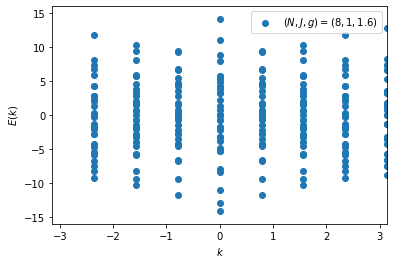

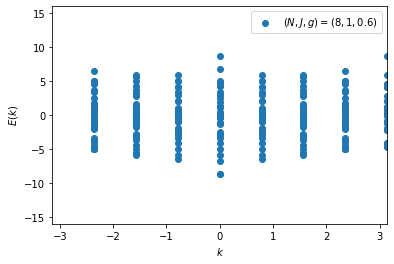

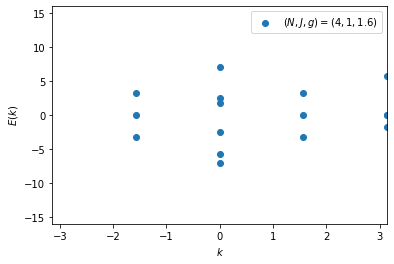

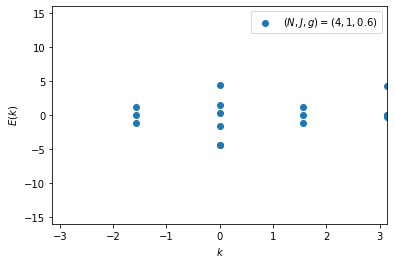

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
for N, J, g in paramList:
    H, T = getHT(N, J, g)
    E, k = getDispersion(H, T)
    plt.scatter(k, E)
    plt.xlim(-np.pi, np.pi)
    plt.xlabel(r'$k$')
    plt.ylim(-16, 16)
    plt.ylabel(r'$E(k)$')
    plt.legend([f'$(N, J, g)=({N}, {J}, {g})$'])
    plt.show()

## Analytical Solution
The analytical solution can be obtained by applying Jordan-Wigner and Bogliubov transformation.

The result is as follows:
$$
H = \sum_k \epsilon_k \gamma_k^\dagger \gamma_k - \epsilon_0,
$$
where $\gamma_k^\dagger, \gamma_k$ are creation and annihilation operaters of non interaction fermions (at most N of them), and
$$
\epsilon_k = 2J\sqrt{1+g^2-2g\cos{k}},
$$
$$
\epsilon_0 = J\sum_k\sqrt{1+g^2-2g\cos{k}}.
$$
Note that when $g > 1$, summation of $k$ takes $2\pi/N$ times integers for odd number of fermions and half-integers for even number.

When $g < 1$, summation takes only even number of fermions for both integer and half-integer $k$ s.

In [8]:
def epsilon(J, g, k):
    return J * np.sqrt(1 + g ** 2 - 2 * g * np.cos(k))

In [9]:
def getAnalyticalSol(N, J, g):
    kList=[
        (np.arange(0, N, 1) + 1/2) * 2 * np.pi / N, # half-integer
        np.arange(0, N, 1) * 2 * np.pi / N, # integer
    ]

    E = []
    for ki in range(2):
        for config in range(2 ** N):
            energy = 0
            if g > 1:
                num = bin(config).count('1')
                if not ki ^ (num % 2): # half-integer for even, integer for odd
                    ks = kList[ki]
                else: 
                    continue
            
            if g < 1:
                num = bin(config).count('1')
                if num % 2: # only even
                    continue
                ks = kList[ki]

            energy -= np.sum(epsilon(J, g, ks))
            # print(epsilon(J, g, ks))
            # print('-e0', bin(config), energy)
            for pos in range(N):
                if readBit(config, pos):
                    energy += 2 * epsilon(J, g, ks[pos])
                    # print('+ek', bin(config), pos, energy)

            E.append(energy)
        
    return np.sort(E)

## Compare Results
Finally, we can compare the results from exact diagonalization and analytical solution.

In [10]:
for N, J, g in [(4, 1, 1.6), (4, 1, 0.6)]:
    H, T = getHT(N, J, g)
    E, k = getDispersion(H, T)
    EAS = getAnalyticalSol(N, J, g)
    print(f"Exact Diag.:\n{np.sort(E)}\n Analytical Sol.:\n{EAS}")
    print(f"Whether |ED-AS| < 1e-10:\n{np.abs(np.sort(E)-EAS)<1e-10}")

Exact Diag.:
[-7.10401652e+00 -5.77359245e+00 -3.20000000e+00 -3.20000000e+00
 -2.54812662e+00 -1.77359245e+00 -1.16489957e-17 -2.82913218e-18
 -6.17508847e-32 -6.17508847e-32  1.77359245e+00  2.54812662e+00
  3.20000000e+00  3.20000000e+00  5.77359245e+00  7.10401652e+00]
 Analytical Sol.:
[-7.10401652e+00 -5.77359245e+00 -3.20000000e+00 -3.20000000e+00
 -2.54812662e+00 -1.77359245e+00  0.00000000e+00  0.00000000e+00
  4.44089210e-16  4.44089210e-16  1.77359245e+00  2.54812662e+00
  3.20000000e+00  3.20000000e+00  5.77359245e+00  7.10401652e+00]
Whether |ED-AS| < 1e-10:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Exact Diag.:
[-4.40256872e+00 -4.33238076e+00 -1.54187828e+00 -1.20000000e+00
 -1.20000000e+00 -3.32380758e-01 -2.06011412e-18 -3.31950663e-32
 -3.31950663e-32  2.26139885e-18  3.32380758e-01  1.20000000e+00
  1.20000000e+00  1.54187828e+00  4.33238076e+00  4.40256872e+00]
 Analytical Sol.:
[-4.40256872e+00 -4.33238076e+0

Excellent! Both exact diagonalization and analytical solution yield the same results!

# Time Evolution of Wave Packet

Now let's consider another problem regarding time evolution.

We put the wave packet in a tight-binding chain with a gradient field:
$$
H = -\sum_{j=1}^N(\ket{j}\bra{j+1} + \ket{j+1}\bra{j}) + F\sum_{j=1}^N\ket{j}\bra{j},
$$
$$
\ket{\psi(t=0)} = \frac{1}{\sqrt{\Omega}}\sum_j e^{-(\alpha^2/2)(j-N_0)^2} e^{ik_0j}\ket{j},
$$
where we choose $N=101, F=0.1, k_0=\pi/2, \alpha=0.15, N_0=51, t\in[0, 100]$.

In [11]:
N = 101; F = 0.1; k0 = np.pi/2; alpha = 0.15; N0 = 51; tmax = 100

In [12]:
# Hamiltonian
length = N

HFrom = []
HTo = []
HValue = []

for fromBasis in range(length):

    if fromBasis != N-1:
        # H: off-diagonal
        HFrom.append(fromBasis+1)
        HTo.append(fromBasis)
        HValue.append(-1)

        HFrom.append(fromBasis)
        HTo.append(fromBasis+1)
        HValue.append(-1)

    # H: diagonal
    HFrom.append(fromBasis)
    HTo.append(fromBasis)
    HValue.append(F * fromBasis)

H = sparse.coo_matrix((HValue, (HTo, HFrom)), shape=(length, length)).toarray()

In [13]:
HEigVal, HEigVec = np.linalg.eig(H)

## State Vector

After obtaining $E_n$ and $\ket{E_n}$, we construct the initial state vector, a Gaussian wave packet.

In [14]:
idx = np.arange(N)
psi0 = np.exp(- alpha ** 2 / 2 * (idx - N0) ** 2) * np.exp(1j * k0 * idx)
# normalize
psi0 = psi0 / np.sqrt(np.abs(psi0))

## Evolution
Now we change basis to $\ket{E_n}$, in which each component evolves independently:
$$
\braket{E_n|\psi(t)} = e^{-iE_nt}\braket{E_n|\psi(0)}
$$

In [15]:
# change basis to E
psi0E = HEigVec.T @ psi0

# evolution
def evolute(psi0E, HEigVal, t):
    return np.exp(-1j * HEigVal * t) * psi0E

In [16]:
prob = np.zeros((tmax, N))
for t in np.arange(0, tmax, 1):
    psitE = evolute(psi0E, HEigVal, t)
    psit = HEigVec @ psitE
    prob[t] = np.abs(psit) ** 2

## Plotting
Finally, we can visualize the evolution by plotting a heatmap.

The horizontal axis represent different site, while the vertical axis represents time.

The probability $|\braket{j|\psi}|^2$ is represented by the color, ranging from 0 to 1.

The Bloch oscillation can be readily seen from the figure.

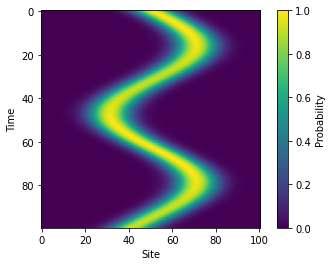

In [17]:
plt.imshow(prob)
plt.xlabel('Site')
plt.ylabel('Time')
plt.colorbar(label='Probability')
plt.show()

## Evolution by Direct Exponentiation

We can also compute the time evolution directly by exponentiating the matrix $H$:
$$
\ket{\psi(t)} = e^{-iHt}\ket{\psi(0)}
$$

In [18]:
from scipy.linalg import expm
def evoluteDirect(psi0, H, t):
    return expm(- 1j * H * t) @ psi0

prob = np.zeros((tmax, N))
for t in np.arange(0, tmax, 1):
    psit = evoluteDirect(psi0, H, t)
    prob[t] = np.abs(psit) ** 2

plt.imshow(prob)
plt.xlabel('Site')
plt.ylabel('Time')
plt.colorbar(label='Probability')
plt.show()

However, direct exponetiation takes considerably longer time compared to computing evolution in the energy representation.

E.g., for $t=1000$, it's 1000 times slower.

In [20]:
%timeit evolute(psi0E, HEigVal, 1000)

5.31 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
%timeit evoluteDirect(psi0, H, 1000)

4.4 ms ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
